## Co-refinement of multiple contrast datasets

A demonstration of how to do co-refinement of several datasets with *refnx*.

In [ ]:
# make sure we have refnx and some other libraries
!pip install refnx matplotlib numpy scipy periodictable

The first step is to import the necessary functionalities from the `refnx` package for reflectometry analysis. You can find the refnx API [here](https://refnx.readthedocs.io/en/latest/modules.html).`matplotlib` is used for plotting, `numpy` is the Python numerical array library, and `scipy` is a Python package for scientific computing.

In [1]:
# The following line is a Jupyter 'magic' and says that we want to plot the graphs in the notebook themselves.
# Other alternatives to 'inline' include 'notebook' and 'qt'
%matplotlib inline
import os.path

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter
from refnx.reflect import SLD, ReflectModel, MaterialSLD, Slab, Structure, MixedReflectModel
import refnx

import scipy
import numpy as np
import matplotlib.pyplot as plt

For reproducible resesearch it's important to know the precise version numbers of the packages you're using, so we could recreate the exact same environment on another computer. Here I'm printing the refnx, scipy and numpy version numbers. It's good reproducibility practice to have these version numbers in each notebook.

In [2]:
print(f'refnx: {refnx.version.version}\nscipy: {scipy.version.version}\nnumpy: {np.version.version}')

refnx: 0.1.25.dev0+e113c4d
scipy: 1.7.1
numpy: 1.20.3


We can also use the `pip freeze` command to list all the packages in a given Python environment:

In [3]:
!pip freeze

appnope==0.1.2
argon2-cffi==21.1.0
arviz==0.11.2
attrs==21.2.0
backcall==0.2.0
beniget==0.4.1
black==21.9b0
bleach==4.1.0
cachetools==4.2.2
cffi==1.14.6
cftime==1.5.0
click==8.0.3
corner==2.2.1
cycler==0.10.0
Cython==0.29.24
debugpy==1.4.3
decorator==5.1.0
defusedxml==0.7.1
dill==0.3.4
dynesty==1.1
entrypoints==0.3
fastprogress==1.0.0
filelock==3.0.12
flake8==4.0.1
future==0.18.2
gast==0.5.2
h5py==3.4.0
iniconfig==1.1.1
ipykernel==6.4.1
ipython==7.27.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
jedi==0.18.0
Jinja2==3.0.1
jsonschema==3.2.0
jupyter-client==7.0.3
jupyter-core==4.8.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
kiwisolver==1.3.2
line-profiler @ git+https://github.com/pyutils/line_profiler.git@1d14155577fc1a36234db4a7e6ea5012cf7d2570
llvmlite==0.37.0
MarkupSafe==2.0.1
matplotlib==3.4.3
matplotlib-inline==0.1.3
mccabe==0.6.1
mistune==0.8.4
mypy-extensions==0.4.3
nbclient==0.5.4
nbconvert==6.1.0
nbformat==5.1.3
nest-asyncio==1.5.1
netCDF4==1.5.7
notebook==6.4.4
numba==

$$\require{mhchem}$$
The datasets we're going to analyse are NR datasets from a solvated polymer film that was deposited onto a Silicon wafer.
![title](Picture1.png)
Here the Silicon is referred to as the *fronting* medium, the water is the *backing* medium. It's important to note that the roughness of the polymer layer describes the SiO2/polymer interface. i.e. the roughness of layer N is between layer N-1/N (with layer 0 being the fronting medium).

We have three datasets measured in $\ce{D2O}$, $\ce{H_2O}$ and HDmix. These datasets are used in refnx testing, and are distributed with every refnx install. We load the datasets into a [`ReflectDataset`](https://refnx.readthedocs.io/en/latest/refnx.dataset.html#refnx.dataset.ReflectDataset) object.

In [4]:
pth = os.path.dirname(refnx.__file__)

e361 = ReflectDataset(os.path.join(pth, 'analysis', 'test', 'e361r.txt'))
e365 = ReflectDataset(os.path.join(pth, 'analysis', 'test', 'e365r.txt'))
e366 = ReflectDataset(os.path.join(pth, 'analysis', 'test', 'e366r.txt'))

Make some [`SLD`](https://refnx.readthedocs.io/en/latest/refnx.reflect.html#refnx.reflect.SLD) objects to represent the scattering length densities of all the materials. Note how the silicon and silicon dioxide are made with `MaterialSLD` objects, that require a chemical formula and a mass density.
If you use an `SLD` object you can fit the real and imaginary parts of an SLD. If you use a `MaterialSLD` you can fit the mass density instead.

In [5]:
si = MaterialSLD('Si', 2.33)
sio2 = MaterialSLD('SiO2', 2.2)
polymer = SLD(2.0, 'polymer')
d2o = SLD(6.36, 'D2O')
h2o = SLD(-0.56, 'H2O')
hdmix = SLD(3.5, 'cm3.5')

The `SLD`s are used to create [`Slab`s](https://refnx.readthedocs.io/en/latest/refnx.reflect.html#refnx.reflect.Slab), which are a type of *`Component`*. 
A Component describes a subset of the interface. You can make a Slab in a few different ways.

In [6]:
# you can make the Slab from an SLD object. The thickness of the SiO2 oxide layer is 30 Å,
# the roughness is 3 Å.
sio2_l = sio2(30, 3)
# this is functionally equivalent to
sio2_l = Slab(30, sio2, 3, name='native SiO2')

# A Slab representing the polymer layer
polymer_l = polymer(160, 3)

We also have to create a Slab for the backing medium. We have to make three different Slabs because there are three contrasts. The roughness of these slabs will describe the water/polymer roughness. This roughness should be the same for all three contrasts. We therefore create a [`Parameter`](https://refnx.readthedocs.io/en/latest/refnx.analysis.html#refnx.analysis.Parameter) for this value, and use it to construct each of the slabs.

In [7]:
water_poly_rough = Parameter(3, 'water_poly_rough')
d2o_l = d2o(0, water_poly_rough)
h2o_l = h2o(0, water_poly_rough)
hdmix_l = hdmix(0, water_poly_rough)

You can use a similar approach when constructing other objects. For example we could've used the following to create `sio2_l`:
```
sio2_thick = Parameter(30, name='sio2 thickness')
sio2_l = sio2(sio2_thick, 3)
```

Let's see the utility of using a single Parameter for all three slabs. First of all print out some of the slabs, change the roughness parameter, then print out the slabs again. You'll see that changing a single parameter affects all the slabs components.

In [8]:
print(d2o_l, '\n', h2o_l)
water_poly_rough.setp(5.0)
print("\nNow we've updated the roughness")
print(d2o_l, '\n', h2o_l)

________________________________________________________________________________
Parameters:      'D2O'     
<Parameter: 'D2O - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'D2O - sld'  , value=6.36 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'water_poly_rough', value=3 (fixed)  , bounds=[-inf, inf]>
<Parameter:'D2O - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]> 
 ________________________________________________________________________________
Parameters:      'H2O'     
<Parameter: 'H2O - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'H2O - sld'  , value=-0.56 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'H2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'water_poly_rough', value=3 (fixed)  , bounds=[-inf, inf]>
<Parameter:'H2O - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>

Now we've updated the roughness
__________________________________________________

The next step is to indicate which parameters we wish to vary, and the limits you want to set on those parameters. For each of the contrasts the polymer material doesn't exchange protons, so the `polymer` SLD should be the same for each of the contrasts. However, the polymer layer is swollen by the solvent. By default the solvation is performed by the backing material, but it's possible to specify that. The following cell shows all the different parameters that are fittable in a Slab component.

In [9]:
sio2_l.thick.setp(vary=True, bounds=(1, 50))

# vary the thickness of the polymer layer
polymer_l.thick.setp(vary=True, bounds=(150, 300))

# all the real part of the SLD of the polymer layer to vary between [0.1, 2].
# the same SLD is going to be used for all three contrasts.
polymer_l.sld.real.setp(vary=True, bounds=(0.1, 2))
# this is functionally equivalent to:
polymer.real.setp(vary=True, bounds=(0.1, 2))

# if we want to fit the sio2/polymer interfacial roughness
# polymer_l.rough.setp(vary=True, bounds=(1, 5))

# the volume fraction of solvent in the polymer layer.
polymer_l.vfsolv.setp(vary=True, bounds=(0, 1))

water_poly_rough.setp(vary=True, bounds=(1, 10))

# if we wanted to fit the mass density of the SiO2
# sio2_l.sld.density.setp(vary=True, bounds=(2, 3))
# -or-
# sio2.density.setp(vary=True, bounds=(2, 3))

In [10]:
# you can discover the parameters contained in a refnx object like so
# A `Parameters` object is list-like.
polymer_l.parameters

Parameters(data=[Parameter(value=160.0, name='polymer - thick', vary=True, bounds=Interval(lb=150.0, ub=300.0), constraint=None), Parameter(value=2.0, name='polymer - sld', vary=True, bounds=Interval(lb=0.1, ub=2.0), constraint=None), Parameter(value=0.0, name='polymer - isld', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=3.0, name='polymer - rough', vary=False, bounds=Interval(lb=-np.inf, ub=np.inf), constraint=None), Parameter(value=0.0, name='polymer - volfrac solvent', vary=True, bounds=Interval(lb=0.0, ub=1.0), constraint=None)], name='polymer')

A [`Structure`](https://refnx.readthedocs.io/en/latest/refnx.reflect.html#refnx.reflect.Structure) is created for each dataset we want to fit. The `Structure` is a series of `Components` that comprise the interface of interest. It's important to note here that the `Structure`s all share the same `si`, `sio2_l`, `polymer_l` objects. This means the `Structure`s share the same parameters. The only thing that's different is the contrast. By default the `Structure` object solvates with the SLD of the last slab, the *backing* medium.. This behaviour can be modified by changing the `Structure.solvent` attribute.

In [11]:
structure361 = si | sio2_l | polymer_l | d2o_l
structure365 = si | sio2_l | polymer_l | hdmix_l
structure366 = si | sio2_l | polymer_l | h2o_l

# this is functionally equivalent (a Structur is list-like)
# note how we specify that the solvent is going to be the 'd2o' SLD object
structure361 = Structure(solvent=d2o)
structure361.append(si)
structure361.append(sio2_l)
structure361.append(polymer_l)
structure361.append(d2o_l)

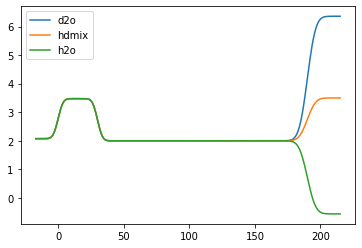

In [12]:
# let's plot the SLD profiles for these structures.
plt.plot(*structure361.sld_profile(), label='d2o')
plt.plot(*structure365.sld_profile(), label='hdmix')
plt.plot(*structure366.sld_profile(), label='h2o')
plt.legend();

Create a [`ReflectModel`](https://refnx.readthedocs.io/en/latest/refnx.reflect.html#refnx.reflect.MixedReflectModel) from the `Structure`. These are responsible for calculating the generative model, doing resolution smearing, applying a scale factor, and adding a Q-independent constant background. [`MixedReflectModel`](https://refnx.readthedocs.io/en/latest/refnx.reflect.html#refnx.reflect.MixedReflectModel) can be used if the illuminated area is composed of several different types of structures (e.g. a patchy bilayer).

In [13]:
model361 = ReflectModel(structure361, bkg=1e-5)
model365 = ReflectModel(structure365, bkg=1e-5)
model366 = ReflectModel(structure366, bkg=1e-5)

# we're going to fit the scale factor, and a linear background. You can also fit a q-offset,
# and the resolution if you want to.
model361.scale.setp(vary=True, bounds=(0.9, 1.1))
model361.bkg.setp(vary=True, bounds=(0.9e-8, 3e-5))

model365.scale.setp(vary=True, bounds=(0.9, 1.1))
model365.bkg.setp(vary=True, bounds=(0.9e-8, 3e-5))

# we won't fit the scale factor for h2o because there's no critical edge.
model366.bkg.setp(vary=True, bounds=(0.9e-8, 3e-5))

[`Objective`](https://refnx.readthedocs.io/en/latest/refnx.analysis.html#refnx.analysis.Objective)s are created from the datasets and the model. Here we also add a `Transform` to fit as logR vs Q.

In [14]:
objective361 = Objective(model361, e361, transform=Transform('logY'))
objective365 = Objective(model365, e365, transform=Transform('logY'))
objective366 = Objective(model366, e366, transform=Transform('logY'))

`Objective`s calculate lots of statistics about the model:

In [15]:
# chi-squared
print(objective361.chisqr())

# log-posterior probability
print(objective361.logpost())

# log-prior probability
print(objective361.logp())

# the generative model array
print(objective361.generative())

# the residuals array
print(objective361.residuals())

70860.72036139156
-35118.46403254381
0.28251707802972437
[9.99963276e-01 9.99963466e-01 9.99963705e-01 9.99963991e-01
 9.99964317e-01 9.99964806e-01 9.99960264e-01 9.69026173e-01
 5.23897557e-01 2.33646155e-01 1.34151075e-01 9.01829473e-02
 6.20758266e-02 4.80005339e-02 3.68273006e-02 3.03045724e-02
 2.45117303e-02 1.89317539e-02 1.44272796e-02 1.14071979e-02
 9.01306179e-03 7.08013881e-03 5.33144505e-03 4.08280931e-03
 3.07381697e-03 2.18165351e-03 1.57279264e-03 1.11123342e-03
 7.39995615e-04 5.18605884e-04 3.79443993e-04 2.99309615e-04
 2.78434224e-04 2.90293749e-04 3.22736175e-04 3.71182593e-04
 4.15831865e-04 4.55502014e-04 4.88805165e-04 5.05421082e-04
 5.08605465e-04 4.96281006e-04 4.72410473e-04 4.38300053e-04
 3.90591465e-04 3.42738270e-04 2.92482072e-04 2.36143555e-04
 1.88658976e-04 1.45489939e-04 1.07988219e-04 7.36648675e-05
 5.05990279e-05 3.45106769e-05 2.42320170e-05 2.12475566e-05
 2.30672322e-05 3.14068197e-05 4.38136867e-05 5.86906298e-05
 6.99855627e-05 8.02213289e-

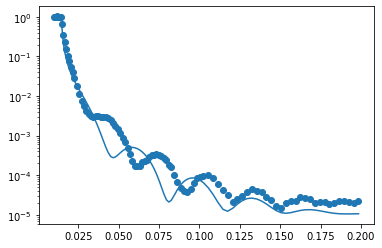

In [16]:
# let's have a look at our initial guess
plt.scatter(e361.x, e361.y)
plt.plot(e361.x, objective361.generative())
plt.yscale('log')

A [`GlobalObjective`](https://refnx.readthedocs.io/en/latest/refnx.analysis.html#refnx.analysis.GlobalObjective) is formed from the individual `Objective`s. This means that they're all analysed together. You can do all the same things you would with `Objective` with a `GlobalObjective` object. In the plot command here we  use the `parameter` keyword to create an interactive plot. If the following cell doesn't work you may need to install `ipywidgets` (uncomment the second line and execute it). Try varying the slider to figure out the ball-park film thickness.

<IPython.core.display.Javascript object>


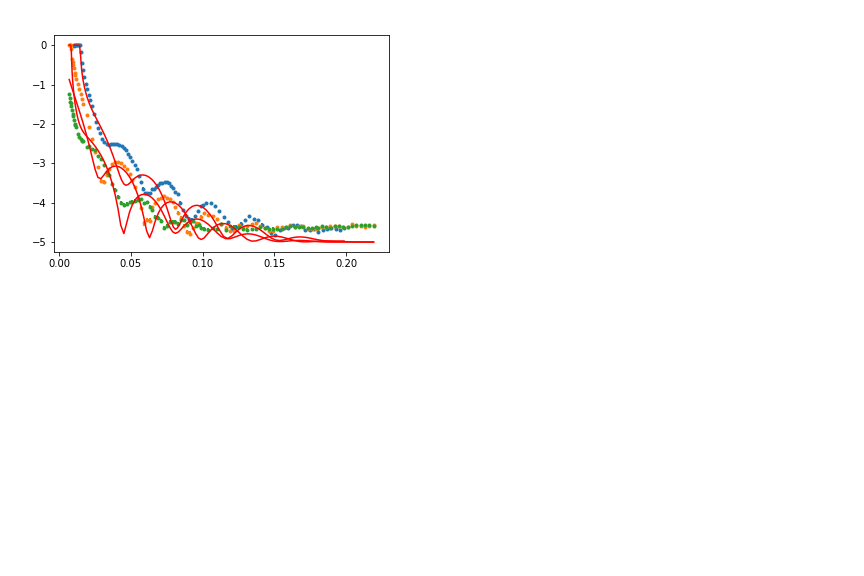

interactive(children=(FloatSlider(value=160.0, description='val', max=480.0, min=-160.0), Output()), _dom_clas…

In [17]:
%matplotlib notebook
# %pip install ipywidgets;
global_objective = GlobalObjective([objective361, objective365, objective366])
global_objective.plot(parameter=polymer_l.thick)
plt.legend();

Now we create a [`CurveFitter`](https://refnx.readthedocs.io/en/latest/refnx.analysis.html#refnx.analysis.CurveFitter) and fit with differential evolution.

In [18]:
# create the fit instance
fitter = CurveFitter(global_objective)
fitter.fit('differential_evolution');

44it [00:19,  2.21it/s]


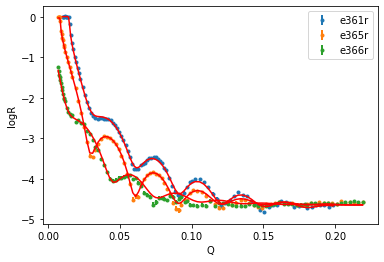

In [19]:
%matplotlib inline
global_objective.plot()
plt.legend()
plt.xlabel('Q')
plt.ylabel('logR');

In [20]:
print(global_objective)

_______________________________________________________________________________

--Global Objective--
________________________________________________________________________________
Objective - 140294206190928
Dataset = e361r
datapoints = 99
chi2 = 451.9023688540995
Weighted = True
Transform = Transform('logY')
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1.02029 +/- 0.0024, bounds=[0.9, 1.1]>
<Parameter:     'bkg'     , value=1.84998e-05 +/- 3.87e-07, bounds=[9e-09, 3e-05]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
___________________________________________________________

Now we're going to do some MCMC sampling to understand the parameter uncertainties in a robust fashion. `refnx` uses MCMC to estimate the posterior distribution for the parameters, $p(\theta | D, I)$. For more details on this approach please refer to the refnx paper. The MCMC sampler we use is called `emcee`, and it iterates over a set of walkers (also called chains). Each iteration/step is designed so that the walkers will visit more probable regions of the the posterior distribution more frequently compared to less probable regions (in a correctly weighted fashion).

Given that the differential evolution fit was quite good we initialise the sampler using the covariance matrix for the system. This will distribute the walkers around the equilibrium position (aka the parameter mean/median) for each parameter. If the fit is not good then other initialisation methods can be used (e.g. `'jitter'`, `'prior'`). The sampler must then be run enough for the walkers to be distributed according to their equilibrium positions and those samples discarded. (`fitter.reset()`).

In [21]:
model361.threads = 1
model365.threads = 1
model366.threads = 1

In [22]:
fitter.initialise('covar', random_state=1)
fitter.sample(1000, random_state=1);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:34<00:00,  4.67it/s]


We first need to understand the autocorrelation time. Each step in an MCMC analysis is created from the previous step, so the steps are correlated. The autocorrelation time specifies how many steps are required from any given position of the sampler for this correlation to be zero.

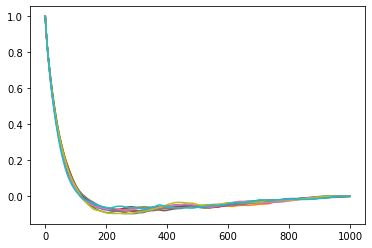

In [23]:
# plot the autocorrelation for each of the parameters
plt.plot(fitter.acf());

It looks like the autocorrelation time is ~200. This means if we save 1 in every 250 steps the steps will be independent of each other. We'll therefore reset the sampler state and do a production run, *thinning* to a factor of 200. We'll collect a total of 10 steps (requiring a total step count of $10 * 200 = 2000$).

In [24]:
fitter.reset()
fitter.sample(10, nthin=200, random_state=1);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:08<00:00,  5.43it/s]


We can examine the fitted parameters and their uncertainties. The reported parameter value is the median of the samples, with the uncertainty reported as half of the [15.8, 84.2] quartile range. If a parameter follows a normal distribution this corresponds to the mean and standard deviation.

In [25]:
print(global_objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.01977 +/- 0.00243, bounds=[0.9, 1.1]>
<Parameter:     'bkg'     , value=1.8524e-05 +/- 3.82e-07, bounds=[9e-09, 3e-05]>
<Parameter:'native SiO2 - thick', value=8.74582 +/- 0.29 , bounds=[1.0, 50.0]>
<Parameter:'polymer - thick', value=211.08 +/- 0.203, bounds=[150.0, 300.0]>
<Parameter:'polymer - sld', value=0.247377 +/- 0.00648, bounds=[0.1, 2.0]>
<Parameter:'polymer - volfrac solvent', value=0.023609 +/- 0.00245, bounds=[0.0, 1.0]>
<Parameter:'water_poly_rough', value=6.10663 +/- 0.197, bounds=[1.0, 10.0]>
<Parameter:    'scale'    , value=0.945353 +/- 0.00408, bounds=[0.9, 1.1]>
<Parameter:     'bkg'     , value=2.1919e-05 +/- 2.47e-07, bounds=[9e-09, 3e-05]>
<Parameter:     'bkg'     , value=2.1548e-05 +/- 2.44e-07, bounds=[9e-09, 3e-05]>


A corner plot allows us to visualise the covariance matrix.

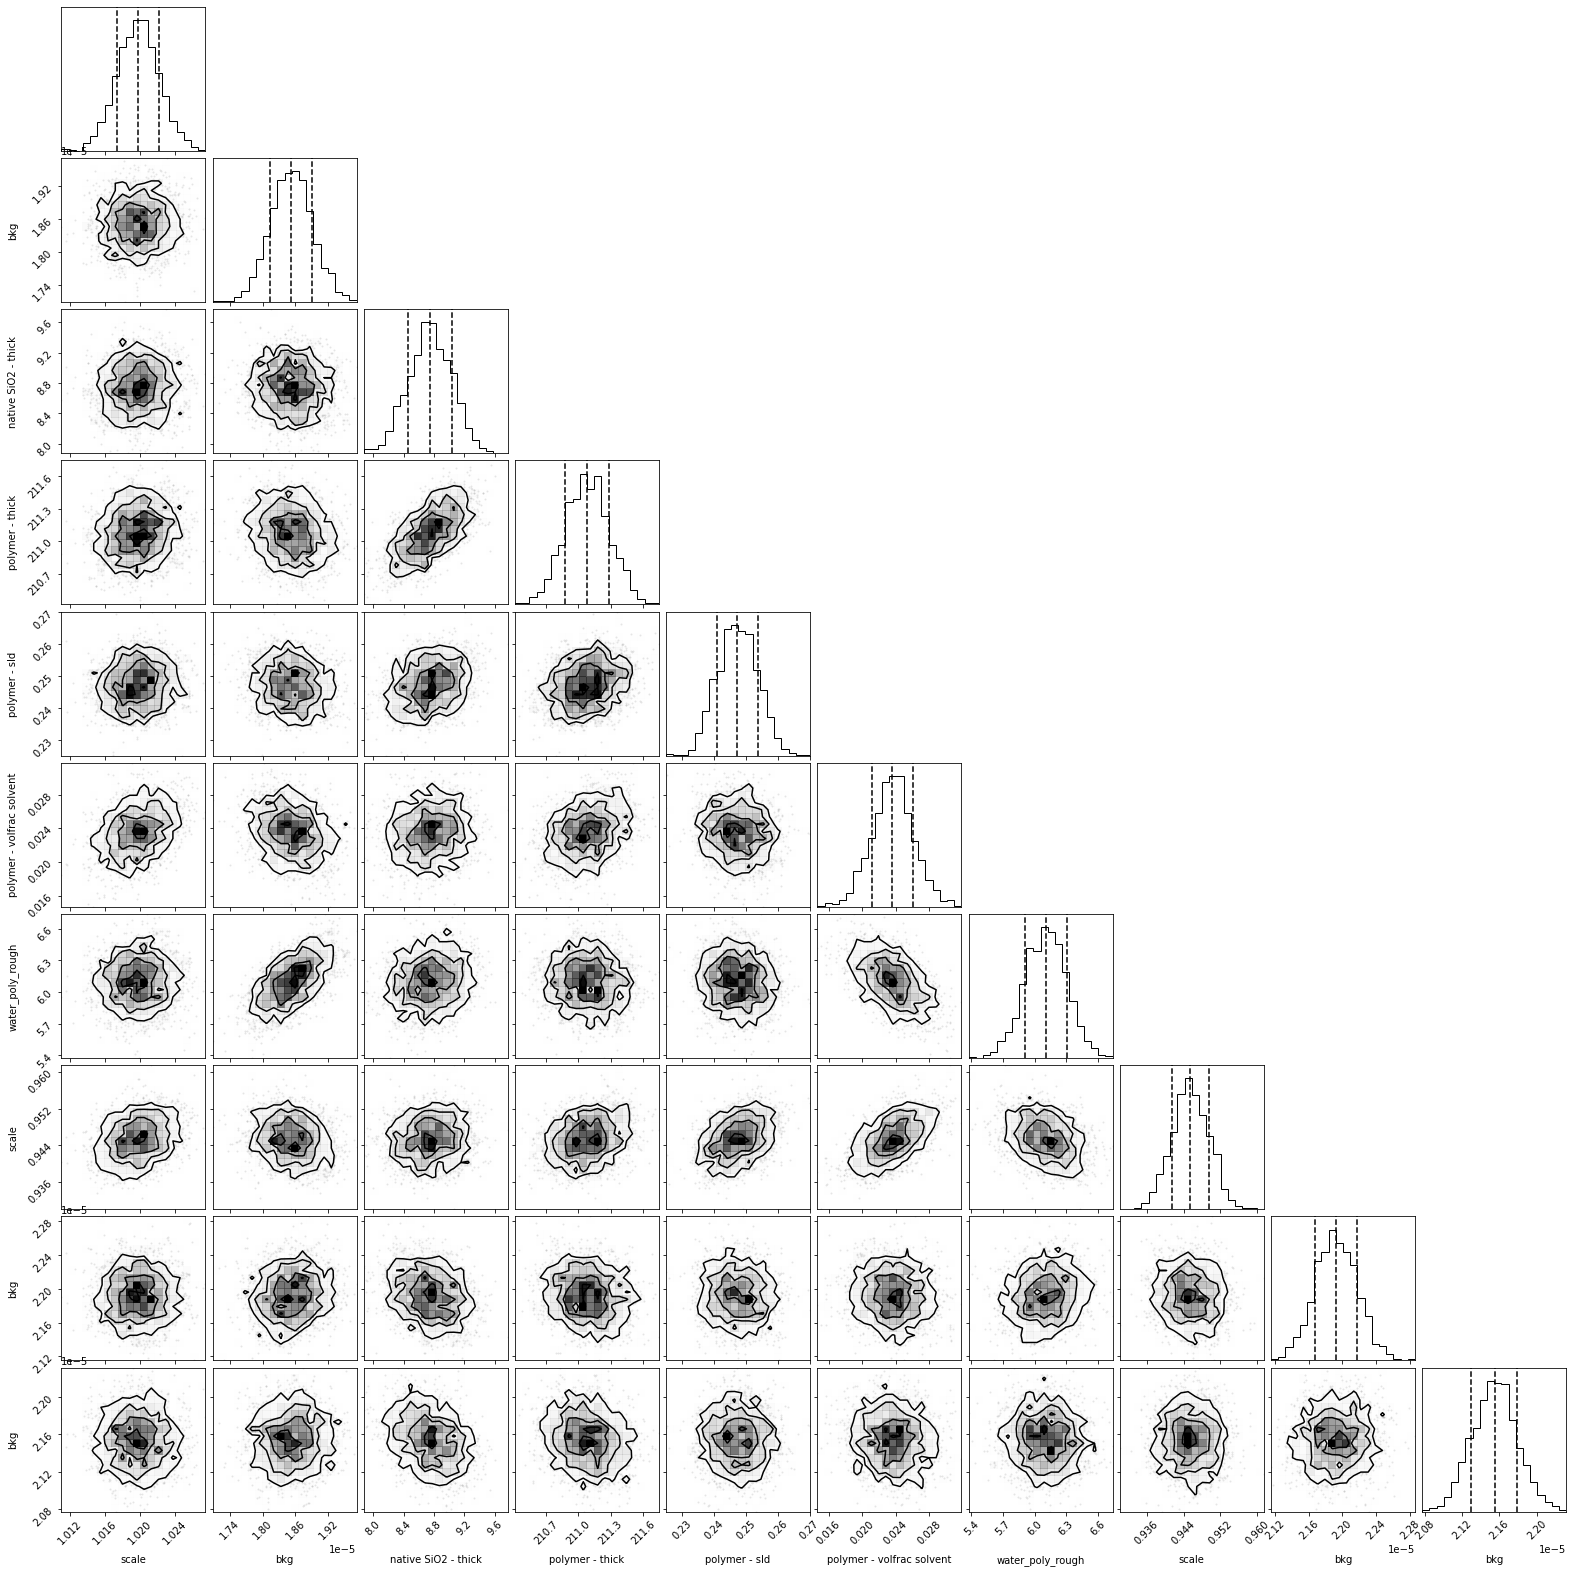

In [26]:
global_objective.corner();